In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
import warnings

In [19]:
marketdf = pd.read_excel("/Users/gabriel/Library/Mobile Documents/com~apple~CloudDocs/SMU Masters /QF600 Asset Pricing/Assignment Codes/Market_Portfolio.xlsx")
print(marketdf.head())
industrydf = pd.read_excel("/Users/gabriel/Library/Mobile Documents/com~apple~CloudDocs/SMU Masters /QF600 Asset Pricing/Assignment Codes/Industry_Portfolios.xlsx")
industrydf = industrydf.drop(columns="Date")
marketdf = marketdf.drop(columns="Date")
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")
rf = 0.13

     Date  Market
0  200401    2.22
1  200402    1.46
2  200403   -1.23
3  200404   -1.75
4  200405    1.23


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [20]:
def MarketModel(data_portfolio, rf, data_market):
    data_portfolio = data_portfolio.copy()
    data_market = data_market.copy()
    data_market = data_market.reindex(data_portfolio.index)
    excess_market_returns = data_market.squeeze() - rf 
    excess_portfolio_returns = data_portfolio - rf   
    
    alphas = []
    betas = []
    r_squared = []
    correlations = []
    
    portfolios = excess_portfolio_returns.columns.tolist()
    for portfolio in portfolios:
        y = excess_portfolio_returns[portfolio]
        x = excess_market_returns
        df = pd.concat([x, y], axis=1).dropna()
        x_clean = df.iloc[:, 0].values.reshape(-1, 1)
        y_clean = df.iloc[:, 1].values                 
        model = LinearRegression().fit(x_clean, y_clean)
        alpha = model.intercept_
        beta = model.coef_[0]
        r2 = model.score(x_clean, y_clean)
        corr = np.corrcoef(x_clean.flatten(), y_clean)[0, 1]
        alphas.append(alpha)
        betas.append(beta)
        r_squared.append(r2)
        correlations.append(corr)
    
    results = pd.DataFrame({
        'Alpha': alphas,
        'Beta': betas,
#         'R-squared': r_squared,
#         'Correlation': correlations
    }, index=portfolios)

    results.loc['Market'] = [0.0, 1.0]
    results = results.round(6)
    
    return results


def plot_SML(beta_range, sml_line, capm_data):
    plt.figure(figsize=(10, 6))
    plt.plot(beta_range, sml_line, label='Security Market Line (SML)', color='red')
    plt.scatter(capm_data['Beta'], capm_data['Mean_Return'], color='blue', label='Portfolios and Market')
    plt.xlabel('Beta')
    plt.ylabel('Mean Monthly Return (%)')
    plt.title('Security Market Line (SML)')
    plt.legend()
    plt.grid(True)
    plt.show()

def CAPM_SML(data_portfolio, data_market, rf, market_model_results):
    mean_returns_portfolio = data_portfolio.mean()
    mean_return_market = data_market.mean()[0]

    capm_data = pd.DataFrame({
        'Mean_Return': mean_returns_portfolio,
        'Beta': market_model_results.loc[data_portfolio.columns, 'Beta']
    })

    market_data = pd.DataFrame({
        'Mean_Return': [mean_return_market],
        'Beta': [1]
    }, index=['Market'])

    capm_data = pd.concat([capm_data, market_data])

    X = capm_data['Beta'].values.reshape(-1, 1)
    Y = capm_data['Mean_Return'].values
    capm_model = LinearRegression().fit(X, Y)
    capm_alpha = capm_model.intercept_
    capm_beta = capm_model.coef_[0]
    capm_r_squared = capm_model.score(X, Y)

    print(f"CAPM Regression Results:")
    print(f"Alpha (Risk-Free Rate Estimate): {capm_alpha:.6f}%")
    print(f"Beta (Market Risk Premium Estimate): {capm_beta:.6f}")
#     print(f"R-squared: {capm_r_squared:.6f}")

#     beta_range = np.linspace(0, 2, 100)
#     sml_line = capm_alpha + capm_beta * beta_range
#     plot_SML(beta_range, sml_line, capm_data)

    # Plotting the SML
    beta_range = np.linspace(0, 2, 100)
    sml_line = capm_alpha + capm_beta * beta_range

    # Plot the SML and data points
    plt.figure(figsize=(10, 6))
    plt.plot(beta_range, sml_line, label='Security Market Line', color='blue')
    
    # Plot individual portfolio points
    plt.scatter(capm_data['Beta'], capm_data['Mean_Return'], color='green', label='Portfolios')

    # Highlight the market portfolio as a red dot
    plt.scatter(1, mean_return_market, color='red', label='Market Portfolio', s=100)

    # Add labels and title
    plt.title('Security Market Line (SML)')
    plt.xlabel('Beta')
    plt.ylabel('Mean Return')
    plt.legend()
    plt.grid(True)

    return capm_data


def format_float(x):
    return '{:.6f}'.format(x)


In [21]:
mm = MarketModel(industrydf, rf, marketdf)

In [22]:
mm['Alpha'] = mm['Alpha'].apply(format_float)
mm

,Alpha,Beta
NoDur,0.369443,0.652647
Durbl,-0.415599,1.648536
Manuf,0.159771,1.169846
Enrgy,0.501719,0.969850
HiTec,-0.064020,1.132969
Telcm,0.194691,0.900729
Shops,0.275492,0.826492
Hlth,0.237841,0.673036
Utils,0.444585,0.538086
Other,-0.387135,1.207309


CAPM Regression Results:
Alpha (Risk-Free Rate Estimate): 1.032768%
Beta (Market Risk Premium Estimate): -0.185467
        Mean_Return      Beta
NoDur      0.902833  0.652647
Durbl      0.733333  1.648536
Manuf      1.012833  1.169846
Enrgy      1.231167  0.969850
HiTec      0.766250  1.132969
Telcm      0.881417  0.900729
Shops      0.916333  0.826492
Hlth       0.783833  0.673036
Utils      0.907167  0.538086
Other      0.489083  1.207309
Market     0.748083  1.000000


/var/folders/sq/ksw261bx2z55047vw8nlw2280000gn/T/ipykernel_91599/1971539051.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_return_market = data_market.mean()[0]


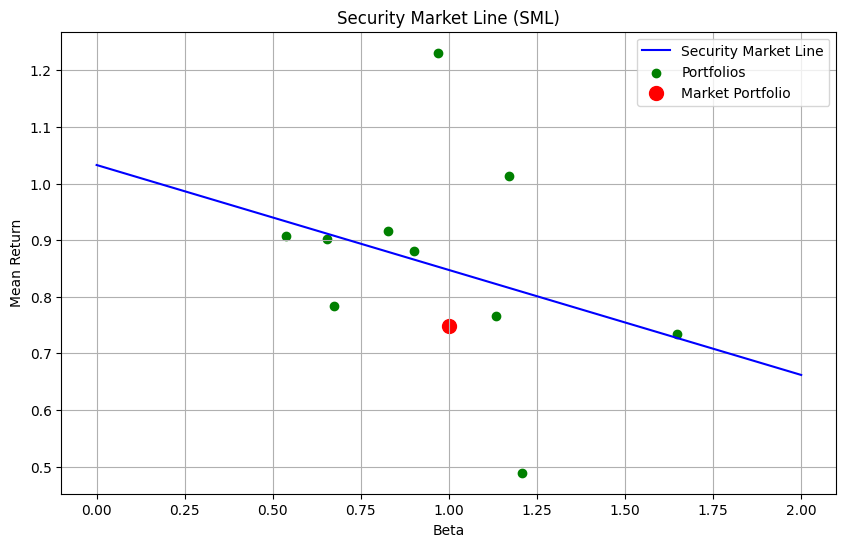

In [23]:
capm_sml = CAPM_SML(industrydf, marketdf, rf, mm)
print(capm_sml)

Q1: In the market model, the alpha ("Intercept") represents the part of the security's return that is independent of the market. It is the portion of the return that cannot be explained by the movements of the overall market movement captured by the market return and epsilon (Unsystematic/Idiosyncratic risk). It reflects an asset's outperformance or underperformance.

Beta is a scalar that reflects the sensitivty of a security's return to the return of the overall market and the asset's exposure or sensitivity to systematic (Market Risk). All else being equal (Alpha and Epsilon), the beta gives the change in the asset's return for a 1 unit change in market return. It can also be a measure of market risk. A Beta > 1 shows that the security is more volatile than the market. Similarly, a Beta of < 1 is less volatile than the market. A Beta of 1 is equal to the market. Finally, a Beta of < 0 shows that the asset moves inversely to the market. 


Q2: The SML is a visual depiction of the risk-return tradeoff. It depicts the expected return for a security given its beta (market risk). It highlights that the asset depends on the risk-free rate, the market risk premium and the asset's beta. To an investor, it answers the question: If my asset has this amount of beta and given the current risk free rate and market return, what should my asset's expected return be. 

For pricing: Assets on the SML are fairly priced and this highlights that their expected return is in line with the level of market risk an investor faces for holding it. Assets above the SML are underpriced because they offer a higher expected return for their level of risk than what the SML says it should have been. This presents a good investment opportunity. Assets below the SML are underpriced because their provide too little returns for the amount of risk an investor takes on when they hold it. 

